In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm 
from scipy import integrate
import warnings 
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
gaiadata=pd.read_csv('gaia_edr3_selected.csv')

In [3]:
gaiadata.columns

Index(['source_id', 'ra', 'dec', 'l', 'b', 'parallax_corr', 'pmra', 'pmdec',
       'phot_g_mean_mag_corr', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error',
       'phot_g_mean_flux_corr', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'r_med_geo', 'r_lo_geo', 'r_hi_geo',
       'r_med_photogeo', 'r_lo_photogeo', 'r_hi_photogeo', 'bp_rp', 'qg_geo',
       'gq_photogeo'],
      dtype='object')

In [4]:
np.random.seed(47+28+13+9+15+32+44+45)
s = np.floor(np.random.randint(0,100000,10))

In [5]:
s

array([ 3879., 15829., 43377., 22524., 17539., 89941., 72107., 17572.,
       59121., 68326.])

In [6]:
data=gaiadata.iloc[s]


In [7]:
uncertainity/parallax

NameError: name 'uncertainity' is not defined

In [7]:
parallax=data.parallax_corr.array
uncertainity=data.parallax_error.array
r=np.linspace(0,20,50001,endpoint=True)

In [314]:
def likelihood(plx,sigma,r):
    return norm.pdf(plx,1/r,sigma)

def uniformprior(r,rlim):
    p=[]
    for i in r:
        if (0<i) & (i<=rlim):
            p.append(1)
        else:
            p.append(0)
    return p

def expdecprior(r,L):
    p=[]
    for i in r:
        if i>0:
            p.append(r**2 * np.exp(-i/L))
        else:
            p.append(0)
    return p

In [315]:
k=2

l = likelihood(parallax[k],uncertainity[k],r)
print('uncertainty = ', uncertainity[k])
print('parallax = ', parallax[k])
print('f_obs = ', uncertainity[k]/parallax[k])


uncertainty =  0.45525286
parallax =  -0.1743555807622093
f_obs =  -2.61105986977776


In [316]:
posterior_uniform = l*uniformprior(r,20)


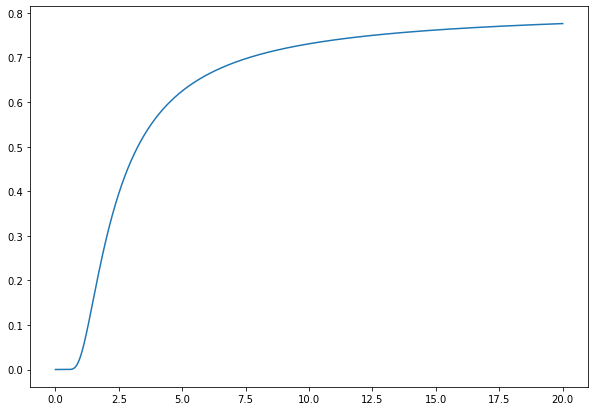

In [317]:
plt.figure(figsize=[10,7])
plt.plot(r,posterior_uniform)

In [24]:
class parallax_distance:
    def __init__(self, parallax,uncertainity):
        self.p=parallax
        self.sigma=uncertainity
        self.f_obs=uncertainity/parallax
        self.r_min=0
        self.r_max=20
    
    
    def create_r(self,r_min,r_max,samples):
        r=np.linspace(r_min,r_max,samples,endpoint=True)
        self.r_max=r_max
        return r
    
    
    ##### PRIORS #######
    
    def likelihood(self,plx,sigma,r):
        return norm.pdf(plx,1/r,sigma)

    def uniformprior(self,r,rlim):
        p=[]
        for i in r:
            if (0<i) & (i<=rlim):
                p.append(1)
            else:
                p.append(0)
        return p

    def expdecprior(self,r,L):
        p=[]
        for i in r:
            if i>0:
                p.append(i**2 * np.exp(-i/L))
            else:
                p.append(0)
        return p
    
    ### POSTERIOR ###
    
    def posterior(self,r, rlim=20, L=None, prior='uniform'):
        if (prior.lower()=='exp') & (L==None):
            print('Parameters for priors not inserted')
            return 0
        if prior.lower()=='uniform':
            return np.array(self.likelihood(self.p,self.sigma,r)*self.uniformprior(r,rlim))
        if prior.lower()=='exp':
            return np.array(self.likelihood(self.p,self.sigma,r)*self.expdecprior(r,L))
        
    def __calc_mean_mod(self,post,r):
        mode=r[np.argmax(post)]
        area=self.area(post,r)
        postnorm=post/area
        median=0
        for i in range(len(r)):
            a=self.area(postnorm[:i+1],r[:i+1])
            if round(a,3)==0.5000:
                median =r[i+1]
                break
        
        
        print("Mode is: " + str(mode))
        print("Median is: " + str(median))
        return median, mode
    
    def area(self, post,r):    
        return integrate.simps(post,r)
    
    def calc_plot_posterior(self,r, rlim=20, L=None, prior='uniform'):
        if prior.lower()=='uniform':
            post=self.posterior(r)
            median,mode=self.__calc_mean_mod(post,r)
            plt.figure(1,figsize=[10,7])
            plt.plot(r,post,'k',lw=3)
            plt.xlabel('r(kpc)',fontsize=12)
            plt.ylabel('posterier probability',fontsize=12)
            plt.title('Uniform prior',fontsize=16)
            plt.text(15,max(post)-1,'fobs : '+str(self.f_obs)[0:8],fontsize=18)
            plt.ylim(-0.1,max(post)+0.5)
            plt.axvline(median,color='red',label='Median')
            plt.axvline(mode,color='blue',label='Mode')
            plt.legend()
            plt.grid()
            plt.show()
        if prior.lower()=='exp':
            if L==None:
                print('Enter L')
                return 0
            post=self.posterior(r,L=L,prior='exp')
            median,mode=self.__calc_mean_mod(post,r)
            plt.figure(figsize=[10,7])
            plt.plot(r,post/self.area(post,r),'k',lw=3)
            plt.xlabel('r(kpc)',fontsize=12)
            plt.ylabel('posterier probability',fontsize=12)
            plt.title('Exponentially decreasing space density prior',fontsize=16)
            plt.text(15,max(post/self.area(post,r)),'fobs : '+str(self.f_obs)[0:8],fontsize=18)
            plt.ylim(-0.1,max(post/self.area(post,r))+0.5)
            plt.axvline(median,color='red',label='Median')
            plt.axvline(mode,color='blue',label='Mode')
            plt.plot(r,self.expdecprior(r,L)/self.area(self.expdecprior(r,L),r),'--')
            plt.legend()
            plt.grid()
            plt.show()

In [25]:
pddd=parallax_distance(parallax[1],uncertainity[1])

In [26]:
r=pddd.create_r(0,20,50000)

Mode is: 4.818496369927399
Median is: 5.273705474109482


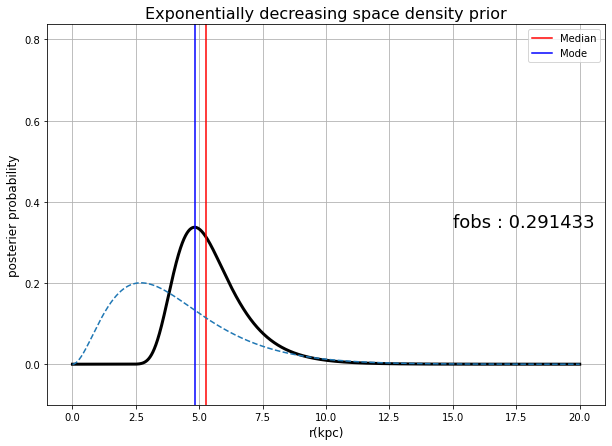

In [27]:
post=pddd.calc_plot_posterior(r,L=1.35,prior='exp')

In [38]:
uncertainity/parallax

<PandasArray>
[0.051857414130793804,   0.2914332897023886,    -2.61105986977776,
    0.554645061787115,   0.3138345401749555,   0.9336557923541684,
    0.287508535344447,  0.18511909472327145,  0.07113652389767512,
  -0.8225304286397639]
Length: 10, dtype: float64